# \<Title\>

Imports

In [94]:
# imports
import sys
import datetime
import dill as pickle
import matplotlib.pyplot as plt

Import custom libraries

In [95]:
# original py files
sys.path.insert(1, r'W:\OneDrive - TU Eindhoven\DS&AI\2024-2025\2024-2025 q1\2AMM20 - Research Topics in Data Mining\Research Project Phase\new_code\methods')

from data_methods import getData, standardize
from dimensionality_reduction import reduce_dimensionality,reduce_with
from beamSearch import EMM, as_string
from adjPysubgroup import adjustedBestFirstSearch, adjustedDFS, adjustedApriori
from qualityMeasures import calc_result_bs, calc_result_ps

set variables

In [96]:
dataset_name = 'Soybean'
reduction_method = 'PCA' # choose from 'PCA' or 'auto_encoder' (others were not implemented yet)

## 1. Data

Open the dataset with name ```dataset_name```.

In [97]:
df, cat, num, features = getData(dataset_name)
df_original = df.copy()

Standardize the DataFrame <font color='red'>move to reduce_dimensionality method??</font>

In [39]:
# standardize
# df_std = standardize(df,num) # ? MOVE TO reduce_dimensionality FUNCTION??

## 2. Reduce Dimensionality

### 2.1 Find Optimal Number of Reduced Features

Set lower and upper bound estimates for the number of features 

In [98]:
l_est, r_est = 2, 12

Compare the <font color='red'>MSE</font> of performing dimensionality reduction to different numbers of features.

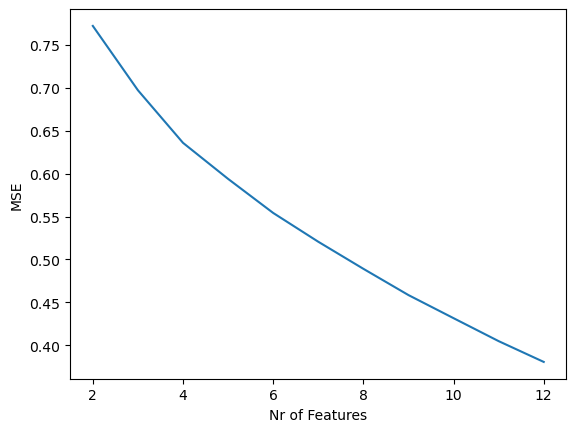

1.820756

In [99]:
t1 = datetime.datetime.now()
mseList = []

for i in range(l_est, r_est+1):

    df_en,mse = reduce_dimensionality(
                    data=df,
                    reduction_method=reduction_method,
                    catColumns=cat,
                    numColumns=num, 
                    nFeatures=i,
                    nEpochs=100
                )

    mseList.append(mse)
t2 = datetime.datetime.now()

plt.plot([i for i in range(l_est, r_est+1)], mseList)
plt.xlabel("Nr of Features") # ! new
plt.ylabel("MSE") # ! new
plt.show()

running_time = t2-t1
running_time.total_seconds()

From the results we can conclude that the optimal number of reduced features is ... 

In [100]:
optimal_nr_features = 6

### 2.2 reduce

In [101]:
df_en,_ = reduce_dimensionality(
            data=df,
            reduction_method=reduction_method,
            catColumns=cat,
            numColumns=num, 
            nFeatures=optimal_nr_features,
            nEpochs=100
        )

df_en.sample(5)

,target,PC1,PC2,PC3,PC4,PC5,PC6
226,1,1.687198,4.803085,-2.461455,-3.079412,1.744951,-0.704939
4,0,4.643951,-0.089932,-1.571048,-0.930338,0.105791,2.892326
91,1,-3.731258,-0.425030,-1.080893,1.347936,-1.525630,1.276793
32,0,5.171208,-2.422535,-0.768408,3.474198,-1.112129,1.128996
141,0,-3.360719,-0.243692,2.924525,4.344070,5.431516,5.080180


## 3. Subgroup Discovery
Run the subgroup discovery algorithms on the dataset.

### 3.1 Best First Search

In [102]:
bfs_results = {}

Find Subgroups

In [109]:
t1 = datetime.datetime.now()
results_df_n = adjustedBestFirstSearch(df)
results_df_n['subgroup'] = results_df_n['subgroup'].apply(lambda x: str(x))[0]
t2 = datetime.datetime.now()
running_time = t2-t1

bfs_results['df']=df
bfs_results['df_results']=results_df_n
bfs_results['df_running_time']=running_time

In [110]:
t1 = datetime.datetime.now()
results_df_en = adjustedBestFirstSearch(df_en)
results_df_en['subgroup'] = results_df_en['subgroup'].apply(lambda x: str(x))[0]
t2 = datetime.datetime.now()
running_time = t2-t1

bfs_results['df_en']=df_en
bfs_results['df_en_results']=results_df_en
bfs_results['df_en_running_time']=running_time

Save subgroups

In [112]:
now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
bfs_file_name = f'bfs-results-{now}.pkl'
with open(bfs_file_name,'wb') as f:
    pickle.dump(bfs_results,f)


Analyze found subgroups

coverage auto-encoding: 256, (0.9624060150375939)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 14 (0.05263157894736842)
# rows no longer in subgroups: 9, (0.03383458646616541)
average subgroup size auto encoded: 20.44
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.07179603143196338, Mean: 0.022610944654870263
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


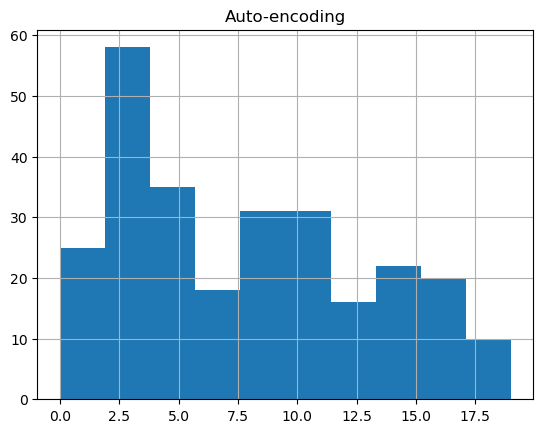

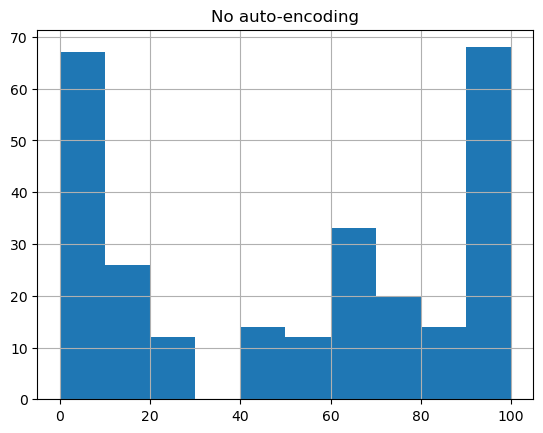

In [28]:
# Loading the object using dill
# with open(bfs_file_name, 'rb') as f:
#     loaded_dict = pickle.load(f)

calc_result_ps(df_en, df, results_df_en, results_df_n)

### 3.2 Beam Search

In [115]:
bs_results = {}

#### 3.2.1 Find Subgroups

In [116]:
t1 = datetime.datetime.now()
results_df_bs = EMM(100, 3, 100, [], df_original, features, 'target', ensure_diversity=True)
t2 = datetime.datetime.now()
bs_running_time = t2-t1
bs_running_time

bs_results['df']=df
bs_results['df_results']=results_df_bs
bs_results['df_running_time']=bs_running_time

level :  0
    seed :  []
eta  []
level :  1
    seed :  ["attribute17 == '1'"]
eta  ["attribute17 == '1'"]
    seed :  ["attribute1 == '4'"]
eta  ["attribute1 == '4'"]
    seed :  ["attribute1 != '1'"]
eta  ["attribute1 != '1'"]
    seed :  ["attribute1 == '1'"]
eta  ["attribute1 == '1'"]
    seed :  ["attribute1 != '4'"]
eta  ["attribute1 != '4'"]
    seed :  ["attribute17 == '0'"]
eta  ["attribute17 == '0'"]
    seed :  ["attribute17 != '1'"]
eta  ["attribute17 != '1'"]
    seed :  ["attribute3 == '1'"]
eta  ["attribute3 == '1'"]
    seed :  ["attribute10 == '2'"]
eta  ["attribute10 == '2'"]
    seed :  ["attribute35 != '2'"]
eta  ["attribute35 != '2'"]
    seed :  ["attribute9 != '1'"]
eta  ["attribute9 != '1'"]
    seed :  ["attribute25 == '0'"]
eta  ["attribute25 == '0'"]
    seed :  ["attribute25 != '1'"]
eta  ["attribute25 != '1'"]
    seed :  ["attribute6 != '2'"]
eta  ["attribute6 != '2'"]
    seed :  ["attribute1 == '2'"]
eta  ["attribute1 == '2'"]


KeyboardInterrupt: 

In [117]:
t1 = datetime.datetime.now()
features_en = [col for col in df_en.columns if col != 'target']
results_bs_df_en = EMM(100, 3, 100, [], df_en, features_en, 'target', ensure_diversity=True,prnt=False)
t2 = datetime.datetime.now()
bs_en_running_time = t2-t1
bs_en_running_time

bs_results['df_en']=df_en
bs_results['df_en_results']=results_bs_df_en
bs_results['df_en_running_time']=bs_en_running_time

level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC2 <= -1.5988893278804068']
eta  ['PC2 <= -1.5988893278804068']
    seed :  ['PC3 > -0.8519585137372201']
eta  ['PC3 > -0.8519585137372201']
    seed :  ['PC1 > -0.4633999079719904']
eta  ['PC1 > -0.4633999079719904']
    seed :  ['PC1 > -3.1159816995973513']
eta  ['PC1 > -3.1159816995973513']
    seed :  ['PC2 <= -0.639784656317392']
eta  ['PC2 <= -0.639784656317392']
    seed :  ['PC2 <= -2.007346885426288']
eta  ['PC2 <= -2.007346885426288']
    seed :  ['PC3 > -1.3903013915034128']
eta  ['PC3 > -1.3903013915034128']
    seed :  ['PC3 > -1.2220225879859798']
eta  ['PC3 > -1.2220225879859798']
    seed :  ['PC1 > -3.328549700736145']
eta  ['PC1 > -3.328549700736145']
    seed :  ['PC3 > -1.5685306866808073']
eta  ['PC3 > -1.5685306866808073']
    seed :  ['PC2 <= -0.2842258105502988']
eta  ['PC2 <= -0.2842258105502988']
    seed :  ['PC1 > -3.41564740365285']
eta  ['PC1 > -3.41564740365285']
    seed :  ['PC5 <= -1.502479926

Save Subgroups

In [121]:
now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
bs_file_name = f'bs-results-{now}.pkl'
with open(bs_file_name,'wb') as f:
    pickle.dump(bfs_results,f)

Analyze Subgroups

In [ ]:
# Loading the object using dill
# with open(bs_file_name, 'rb') as f:
#     loaded_dict = pickle.load(f)

subgroups_n = [i for i in results_df_bs.get_values()]
subgroups_en = [i for i in results_bs_df_en.get_values()]

calc_result_bs(df_en, df, subgroups_en, subgroups_n)

### 4. Interpretability Measures

In [122]:
...

Ellipsis